In [1]:
import collections
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline
%config InlineBackend.figure_format = 'png'

# For recent conferences, I've had HotCRP complain about missing fonts unless I include this line
matplotlib.rcParams['pdf.fonttype'] = 42

In [2]:
def time_to_secs(time_string):
    secs = 0
    tokens = time_string.split(":")
    if len(tokens) == 3:
        hours = int(tokens[0])
        secs += 3600 * hours
        tokens = tokens[1:]
    assert(len(tokens) == 2)
    minutes = int(tokens[0])
    secs += 60 * minutes
    secs += float(tokens[1])
    return secs

In [3]:
TraceTuple = collections.namedtuple("TraceTuple", ("us_size",
                                                   "wall_clock_time",
                                                   "num_major_faults",
                                                   "num_minor_faults",
                                                   "trace_size"))

class TracingSweep(object):
    def __init__(self, stats_filename):
        self.by_uss = {}
        
        with open(stats_filename) as sf:
            sr = csv.DictReader(sf)
            for row in sr:
                us_size = int(row["US_SIZE"])
                self.by_uss[us_size] = TraceTuple(us_size,
                                                  time_to_secs(row["WALLCLOCK"]),
                                                  int(row["MAJOR_FAULTS"]),
                                                  int(row["MINOR_FAULTS"]),
                                                  int(row["TRACE_SIZE"]))

PostprocessTuple = collections.namedtuple("PostprocessTuple", ("us_size",
                                                               "ratio",
                                                               "wall_clock_time",
                                                               "num_major_faults",
                                                               "num_minor_faults",
                                                               "tape_size"))

class PostprocessSweep(object):
    def __init__(self, stats_filename):
        self.by_uss_ratio = {}
        
        with open(stats_filename) as sf:
            sr = csv.DictReader(sf)
            for row in sr:
                us_size = int(row["US_SIZE"])
                ratio = int(row["RATIO"])
                self.by_uss_ratio[(us_size, ratio)] = PostprocessTuple(us_size,
                                                                       ratio,
                                                                       time_to_secs(row["WALLCLOCK"]),
                                                                       int(row["MAJOR_FAULTS"]),
                                                                       int(row["MINOR_FAULTS"]),
                                                                       int(row["TAPE_SIZE"]))

In [4]:
RuntimeTuple = collections.namedtuple("RuntimeTuple", ("ratio",
                                                       "wall_clock_time",
                                                       "num_major_faults",
                                                       "num_minor_faults"))

class RuntimeMicrosetSweep(object):
    def __init__(self, us_sizes, directory_path):
        self.by_uss = {}
        for us_size in us_sizes:
            stats_filename = os.path.join(directory_path, str(us_size), "tape_prefetching_asyncwrites", "time_and_swap_results.csv")
            with open(stats_filename) as sf:
                sr = csv.DictReader(sf)
                for row in sr:
                    self.by_uss[us_size] = RuntimeTuple(int(row["RATIO"]),
                                                        time_to_secs(row["WALLCLOCK"]),
                                                        int(row["MAJOR_FAULTS"]),
                                                        int(row["MINOR_FAULTS"]))

In [5]:
US_SIZES = tuple((1 << i) for i in range(1, 17))

In [6]:
def parse_sweep(experiment_name, sweep_type, base_directory = "microset_sweep", us_sizes = US_SIZES):
    if sweep_type == "tracing":
        filename = os.path.join(base_directory, experiment_name, "trace.stats")
        return TracingSweep(filename)
    elif sweep_type == "postprocessing":
        filename = os.path.join(base_directory, experiment_name, "postp.stats")
        return PostprocessSweep(filename)
    elif sweep_type == "runtime":
        return RuntimeMicrosetSweep(us_sizes, os.path.join(base_directory, experiment_name))
    else:
        raise RuntimeError("Can't handle sweep type {0}".format(sweep_type))

In [7]:
np_mmul_style = {"label": "np_matmul", "color": "brown", "marker": "D", "ls": "-"}
mmul_style = {"label": "matmul", "color": "blue", "marker": "s", "ls": "-"}
mmul3_style = {"label": "matmul_3", "color": "black", "marker": "*", "ls": "-"}
mvmul_style = {"label": "mvmul", "color": "green", "marker": "v", "ls": "--"}
dprod_style = {"label": "dprod", "color": "red", "marker": "o", "ls": ":"}
sparse_style = {"label": "spmul", "color": "purple", "marker": "^", "ls": "-."}

workloads = ["python", "mmult_eigen", "mmult_eigen_par_3", "mmult_eigen_vec", "mmult_eigen_dot", "sparse_eigen"]
styles = [np_mmul_style, mmul_style, mmul3_style, mvmul_style, dprod_style, sparse_style]

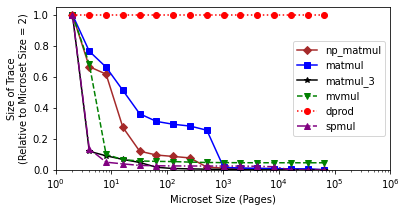

In [8]:
plt.figure(figsize = (6, 3))

for i, workload in enumerate(workloads):
    sweep = parse_sweep(workload, "tracing")
    plt.plot(US_SIZES, [sweep.by_uss[us_size].trace_size / sweep.by_uss[US_SIZES[0]].trace_size for us_size in US_SIZES], **styles[i])

plt.legend()

plt.xlabel("Microset Size (Pages)")
plt.ylabel("Size of Trace\n(Relative to Microset Size = 2)")
    
plt.xscale("log")

plt.xlim(left = 1, right = 10 ** 6)
plt.ylim(bottom = 0)

plt.show()

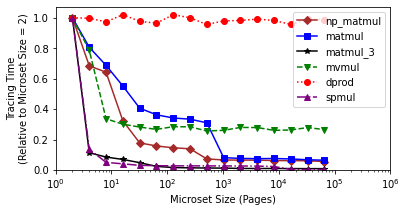

In [9]:
plt.figure(figsize = (6, 3))

for i, workload in enumerate(workloads):
    sweep = parse_sweep(workload, "tracing")
    plt.plot(US_SIZES, [sweep.by_uss[us_size].wall_clock_time / sweep.by_uss[US_SIZES[0]].wall_clock_time for us_size in US_SIZES], **styles[i])

plt.legend()

plt.xlabel("Microset Size (Pages)")
plt.ylabel("Tracing Time\n(Relative to Microset Size = 2)")
    
plt.xscale("log")

plt.xlim(left = 1, right = 10 ** 6)
plt.ylim(bottom = 0)

plt.show()

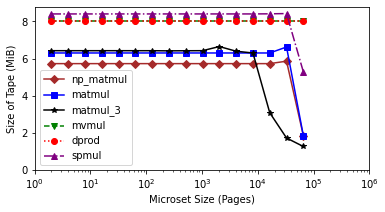

In [10]:
plt.figure(figsize = (6, 3))

for i, workload in enumerate(workloads):
    sweep = parse_sweep(workload, "postprocessing")
    plt.plot(US_SIZES, [sweep.by_uss_ratio[(us_size, 30)].tape_size / (1 << 20) for us_size in US_SIZES], **styles[i])

plt.legend()

plt.xlabel("Microset Size (Pages)")
plt.ylabel("Size of Tape (MiB)")
    
plt.xscale("log")

plt.xlim(left = 1, right = 10 ** 6)
plt.ylim(bottom = 0)

plt.show()

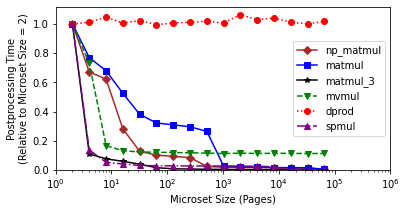

In [11]:
plt.figure(figsize = (6, 3))

for i, workload in enumerate(workloads):
    sweep = parse_sweep(workload, "postprocessing")
    plt.plot(US_SIZES, [sweep.by_uss_ratio[(us_size, 30)].wall_clock_time / sweep.by_uss_ratio[(US_SIZES[0], 30)].wall_clock_time for us_size in US_SIZES], **styles[i])

plt.legend()

plt.xlabel("Microset Size (Pages)")
plt.ylabel("Postprocessing Time\n(Relative to Microset Size = 2)")
    
plt.xscale("log")

plt.xlim(left = 1, right = 10 ** 6)
plt.ylim(bottom = 0)

plt.show()

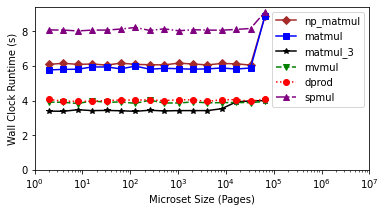

In [12]:
plt.figure(figsize = (6, 3))

for i, workload in enumerate(workloads):
    sweep = parse_sweep(workload, "runtime")
    plt.plot(US_SIZES, [sweep.by_uss[us_size].wall_clock_time for us_size in US_SIZES], **styles[i])

plt.legend()

plt.xlabel("Microset Size (Pages)")
plt.ylabel("Wall Clock Runtime (s)")
    
plt.xscale("log")

plt.xlim(left = 1, right = 10 ** 7)
plt.ylim(bottom = 0)

plt.show()

In [13]:
def smart_round(number):
    if number >= 100:
        return str(int(round(number, 3 - len(str(int(number))))))
    elif number >= 10:
        return "{0:.1f}".format(round(number, 1))
    elif number >= 1:
        return "{0:.2f}".format(round(number, 2))

for i, workload in enumerate(workloads):
    trace_sweep = parse_sweep(workload, "tracing")
    postp_sweep = parse_sweep(workload, "postprocessing")
    
    uss = US_SIZES[0]
    tracet = trace_sweep.by_uss[uss]
    postpt = postp_sweep.by_uss_ratio[(uss, 30)]
    
    print("{0} & {1} & {2} & {3}\\\\\\hline".format(styles[i]["label"],
                                         smart_round(tracet.wall_clock_time),
                                         smart_round(tracet.trace_size / (1 << 20)),
                                         smart_round(postpt.wall_clock_time)))

np_matmul & 82.1 & 1330 & 109\\\hline
matmul & 64.0 & 1010 & 83.6\\\hline
matmul_3 & 656 & 7520 & 312\\\hline
mvmul & 12.6 & 172 & 15.6\\\hline
dprod & 3.41 & 8.00 & 1.75\\\hline
spmul & 2670 & 43800 & 3820\\\hline
